In [11]:
# Lectura del conjunto de datos utilizando Pandas
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import chi2_contingency # Test de independencia
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

dolar = pd.read_csv('dolarMEP.csv')
df = pd.read_csv('lista_prestamos.csv')
df

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia
...,...,...,...,...,...,...,...,...,...
401,10/01/2018,Decoracion,45,21600,Buenos Aires,F,48,48,+180 dias
402,09/01/2018,Otros destinos,36,14000,Santa Fe,D,48,48,+180 dias
403,04/01/2018,Refaccion y construccion de vivienda,50,30000,Buenos Aires,E,48,48,+180 dias
404,04/01/2018,Refaccion y construccion de vivienda,35,32355,Ciudad de Buenos Aires,D,48,48,+180 dias


In [6]:
# Al analizar la base de datos, tendremos que hacer varias modificaciones para representarlo correctamente 
# para ingresos lo pasaremos a dolares utilizando una base de dato donde tenemos según meses el valor máximo de valor mep
# con respecto a la cuota lo dividiremos por el plazo para tener un porcentaje de avance de los pagos 
# con respecto a clases dividiremos en los que son "Al dia" -> "1" y todos los demas como "0"
# cuando ingresemos una nueva entrada lo pasaremos por esta función 

dolar_prueba = dolar.copy()
df_prueba= df.copy()



def editor_fichero(fichero,fichero_dolar):

    def convertir_etiqueta(fichero): #empezamos por class
        fichero.loc[fichero['class'] == 'Al dia', 'class'] = int(1)
        fichero.loc[fichero['class'] != 1, 'class'] = int(0)
        return fichero
    

    #def convertir_cuota_en_porcentaje(fichero): #modificamos las cuotas por un porcentaje de avance del cuota/plazo
    #    fichero['porcentaje_Avance'] = fichero['Cuota']/fichero['Plazo']
    #    del fichero['Cuota']
    #    return fichero
    
    def pasar_ingresos_a_dolares(fichero, fichero_dolar):  #pasar a dolares los ingresos - sacamos el mayor dolar de cada mes y ese será el valor a convertir
       
        #transformamos las columnas de fecha a variable datetime
        fichero['Fecha'] = pd.to_datetime(fichero['Fecha'], dayfirst=True, errors='ignore')
        fichero_dolar['Fecha'] =pd.to_datetime(fichero_dolar['Fecha'], dayfirst=True, errors='ignore')

        #creamos una nueva columna del dolar para esa fecha en particular, luego los ingresos se dividiran por este dolar
        fichero['dolar']=""
        fichero['ingresos en dolares']=""

        for x in range(0,(len(fichero.index)),1):
            cond=False
            cont=0
            dia=pd.to_timedelta('1 days')


            while cond==False:
                cont=cont+1
                for y in range(0,(len(fichero_dolar.index)),1):
                    if (fichero.loc[(x,'Fecha')]+dia*cont)==fichero_dolar.loc[(y,'Fecha')]:
                        fichero.loc[(x,'dolar')] = fichero_dolar.loc[(y,'dolar')]
                        cond=True
                        break  

        fichero['ingresos en dolares'] = (fichero['Ingresos'] / fichero['dolar']).astype('float64')
        
        del fichero['Ingresos']
        del fichero['Fecha']
        del fichero['dolar']
        del fichero['Cuota']
        return fichero
    
    return pasar_ingresos_a_dolares(convertir_etiqueta(fichero),fichero_dolar)


editor_fichero(df_prueba, dolar_prueba)
df_prueba




,Destino,Edad,Zona geografica,Perfil,Plazo,class,ingresos en dolares
0,Refaccion y construccion de vivienda,45,Buenos Aires,A,6,1,1974.450609
1,Decoracion,40,La Pampa,AA,6,1,4843.271727
2,Refaccion y construccion de vivienda,52,Rio Negro,AA,18,1,886.440774
3,Viaje,70,Corrientes,AA,18,1,416.547102
4,Refaccion y construccion de vivienda,57,Buenos Aires,C,6,1,271.800302
...,...,...,...,...,...,...,...
401,Decoracion,45,Buenos Aires,F,48,0,1066.140178
402,Otros destinos,36,Santa Fe,D,48,0,691.016782
403,Refaccion y construccion de vivienda,50,Buenos Aires,E,48,0,1480.750247
404,Refaccion y construccion de vivienda,35,Ciudad de Buenos Aires,D,48,0,1596.989141


In [25]:
# Transformamos los valores del atributo class de categóricos a numéricos
df_encoder=df_prueba
labelencoder = LabelEncoder()
df_encoder['Destino']=labelencoder.fit_transform(df_prueba['Destino'])
df_encoder['Perfil']=labelencoder.fit_transform(df_prueba['Perfil'])
df_encoder['Zona geografica']=labelencoder.fit_transform(df_prueba['Zona geografica'])


# del conjunto que ya procesamos haremos una división de datos de forma aleatoria - datos de entrenamientos 80% - datos de test 10% - 10% datos de validación 
# Separamos el conjunto de datos 80% train set, 20% test set - como afluenta tiene un rango de score vamos a usar para que la división aleatoria
# se realice de forma proporcional del Perfil.

df_prueba
#la función principal de train test split divide en dos conjuntos por esto vamos a realizar una función que me divida en train y set y que tambien el set divida en 2 para tener set y validación
# Construcción de una función que realice el particionado completo se debe poner el fichero, proporcion para train,test,val, y la variable para el stratify
def particionador(df, rstate=42, shuffle=True, st=None):
    strat=df[st]
    train_set, test_set = train_test_split(df, test_size=0.1 , random_state=rstate, shuffle=shuffle , stratify=strat)
    
    df=test_set
    strat=df[st]
    test_set, val_set = train_test_split(df, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    
    return (train_set, val_set, test_set)
    
train_set, val_set, test_set = particionador(df=df_prueba ,rstate=42, shuffle=True, st='Perfil')   
train_set_arbol, val_set_arbol, test_set_arbol = particionador(df=df ,rstate=42, shuffle=True, st='Perfil') 


In [26]:
#transformaremos a traves de Sklearn ->LabelEncoder de valores categóricos a numéricos (Destino-Zona Geografica-Perfil-class)

# Conjunto de datos general
X_df = df_prueba.drop("class", axis=1)
y_df = df_prueba["class"].copy()
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train= train_set["class"].copy()
# Conjunto de datos de validación
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis=1)
y_test= test_set["class"].copy()
labelencoder = LabelEncoder()

y_df= labelencoder.fit_transform(y_df)
y_train = labelencoder.fit_transform(y_train)
y_val = labelencoder.fit_transform(y_val)
y_test= labelencoder.fit_transform(y_test)

# Transformador para codificar únicamente las columnas categóricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._oh = OneHotEncoder()
        self._columns = None
        
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh.toarray(), 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)
    
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])    

# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
        
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)


print(X_train_prep.head(5))

# Transformamos el subconjunto de datos de validación
X_val_prep = data_preparer.transform(X_val)

# Transformamos el subconjunto de datos de validación
X_test_prep = data_preparer.transform(X_test)


     Destino      Edad  Zona geografica  Perfil  Plazo  ingresos en dolares
177   0.0625  0.000000         1.181818    -1.0    1.0             1.087581
243   0.0625  0.078431         0.000000     1.0    0.0            -0.345670
237  -0.1875 -0.078431         0.818182     0.0    0.0            -0.809556
379  -0.1875 -0.235294        -0.363636     0.0    1.0             0.538982
234  -0.1875  1.568627        -0.363636     0.5    1.0             0.590730


F1 Score datos de validación sin preparar utilizando Arbol de decisión: 0.5714285714285714
F1 Score datos de testeo sin preparar utilizando Arbol de decisión: 0.6666666666666666
F1 Score datos de validación preparados utilizando Arbol de decisión: 0.5714285714285714
F1 Score datos de testeo preparado utilizando Arbol de decisión: 0.6666666666666666


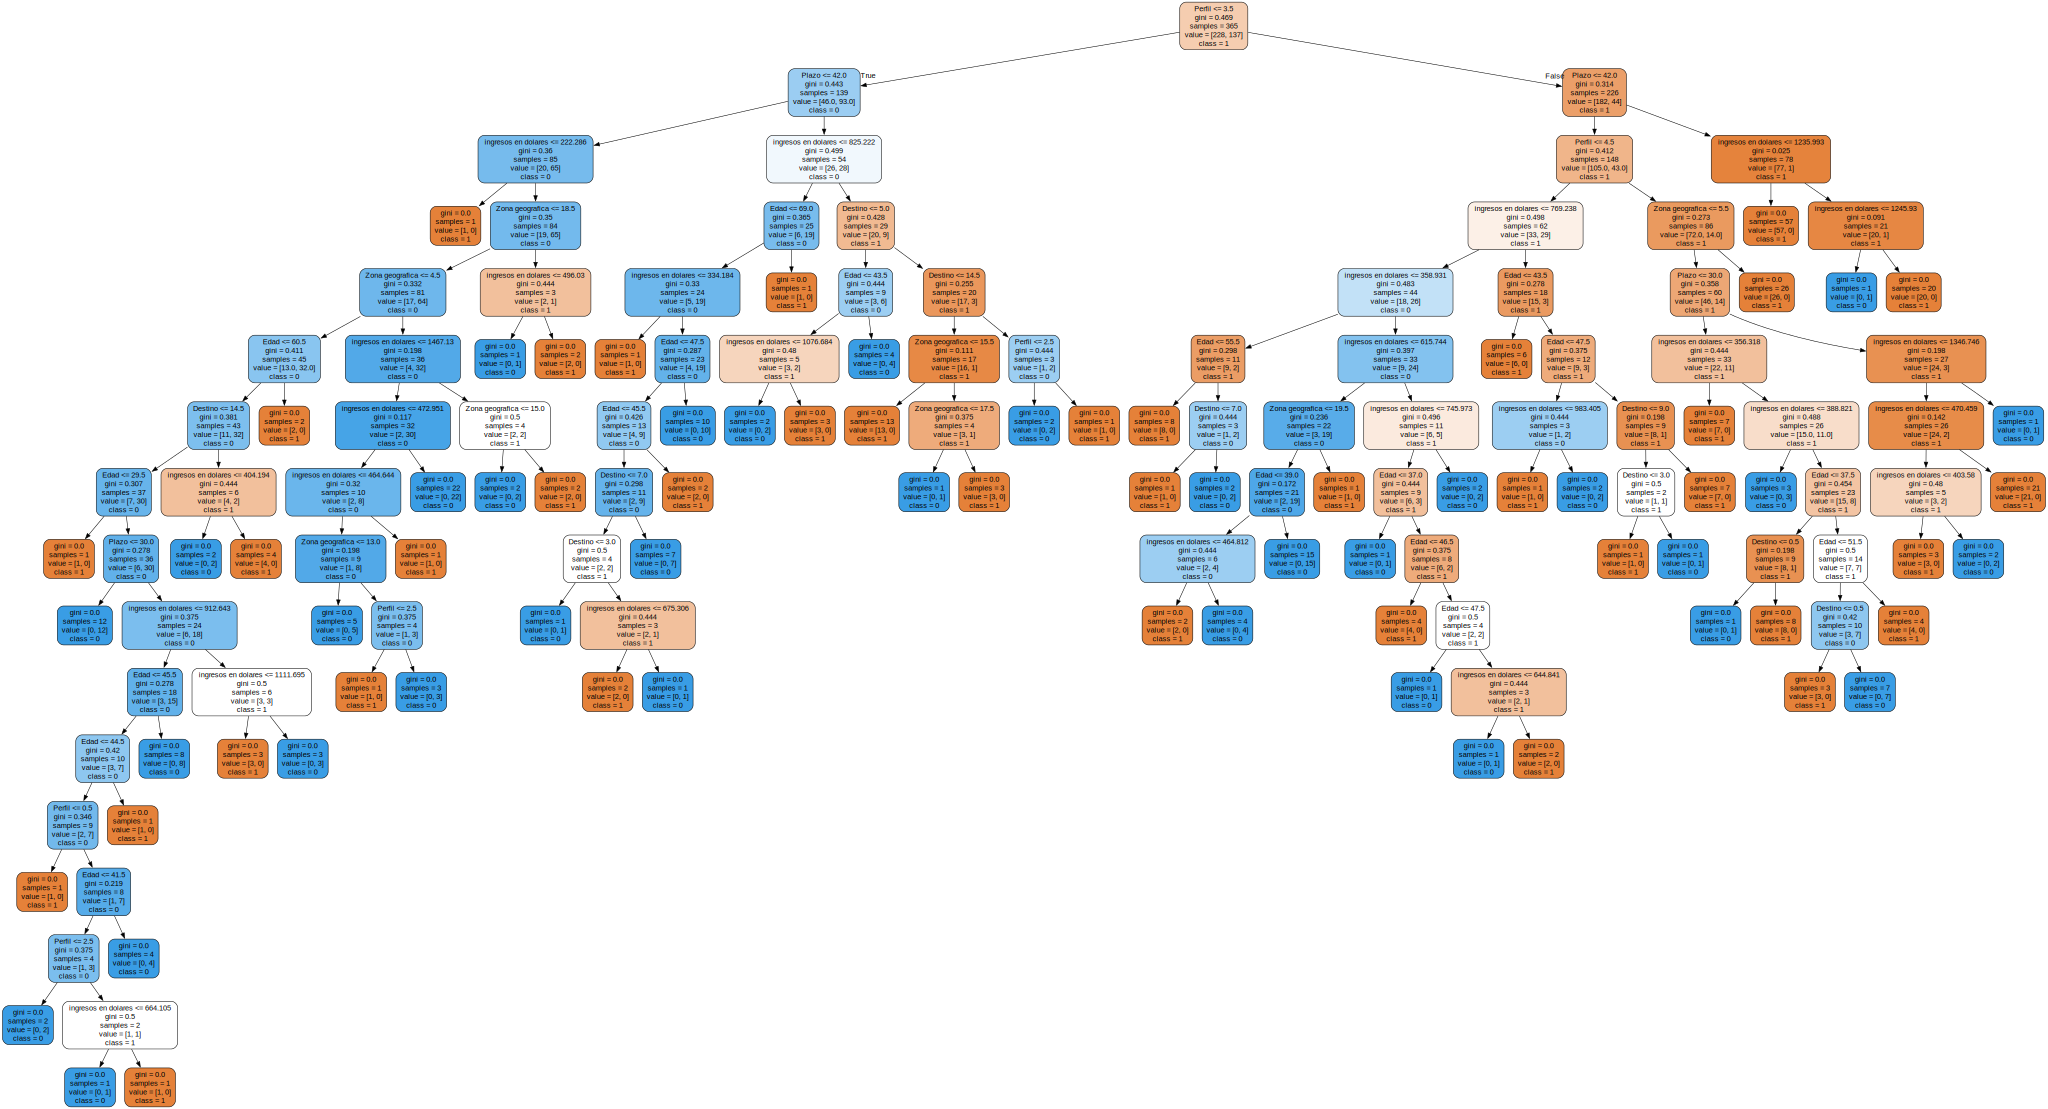

In [27]:
from sklearn.tree import DecisionTreeClassifier

MAX_DEPTH = 100

# Modelo entrenado con el conjunto de datos
clf_tree = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree.fit(X_train, y_train)

# Modelo entrenado con el conjunto de datos escalado
clf_tree_prep = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree_prep.fit(X_train_prep, y_train)


# Predecimos con valores de validación sin preparar
y_val_pred = clf_tree.predict(X_val)
# Predecimos con valores de validación preparado
y_val_pred_prep = clf_tree_prep.predict(X_val_prep)

# Predecimos con valores preparados de testeo
y_test_pred_prep = clf_tree_prep.predict(X_test_prep)
# Predecimos con valores de testeo sin preparar
y_test_pred = clf_tree.predict(X_test)


print("F1 Score datos de validación sin preparar utilizando Arbol de decisión:", f1_score(y_val_pred , y_val))
print("F1 Score datos de testeo sin preparar utilizando Arbol de decisión:", f1_score(y_test_pred , y_test))


print("F1 Score datos de validación preparados utilizando Arbol de decisión:", f1_score(y_val_pred_prep , y_val))
print("F1 Score datos de testeo preparado utilizando Arbol de decisión:", f1_score(y_test_pred_prep , y_test))

# Pintamos el árbol para compararlo con la representación gráfica anterior
from graphviz import Source
from sklearn.tree import export_graphviz
import os
# Preparados
export_graphviz(
        clf_tree,
        out_file="analisis_de_prestamos_preparados.dot",
        feature_names=X_train.columns,
        class_names=["1", "0"],
        rounded=True,
        filled=True
    )

Source.from_file("analisis_de_prestamos_preparados.dot")

# sin Preparar
export_graphviz(
        clf_tree,
        out_file="analisis_de_prestamos_sin_preparar.dot",
        feature_names=X_train_prep.columns,
        class_names=["1", "0"],
        rounded=True,
        filled=True
    )

Source.from_file("analisis_de_prestamos_sin_preparar.dot")

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

# Predecimos con el conjunto de datos de validación
y_val_pred = clf_rnd.predict(X_val)

# Predecimos con el conjunto de datos de validación
y_test_pred = clf_rnd.predict(X_test)

print("F1 Score datos de validación sin preparar utilizando Arbol de decisión:", f1_score(y_val_pred , y_val))
print("F1 Score datos de test sin preparar utilizando Arbol de decisión:", f1_score(y_test_pred , y_test))


F1 Score datos de validación sin preparar utilizando Arbol de decisión: 0.9333333333333333
F1 Score datos de test sin preparar utilizando Arbol de decisión: 0.8235294117647058
